## MNist Neural Network

The goal is to achieve 99.4% validation/test accuracy consistently, with less than 15 epochs and 8k parameters

### Target:

- Get the set-up right
- Set Transforms
- Set Data Loader
- Set Basic Working Code
- Set Basic Training  & Test Loop
- Get the basic skeleton right

### Results:

- Parameters: 26.5k
- Best Training Accuracy: 99.64%
- Best Test Accuracy: 99.00%

### Analysis

- In the initial epochs, the model quickly jumps from ~69% test accuracy (Epoch 1) to ~96% (Epoch 2) and ~98%+ by Epoch 3–4. This shows the network is learning the MNIST features very efficiently even with a small parameter count.
- Training accuracy steadily rises and exceeds 99% around Epoch 10, while test accuracy stabilizes between 98.8–99.0%.
- There is no major overfitting observed — the gap between training and test accuracy remains within ~0.5–0.6%, which is acceptable.
- The model is relatively lightweight (26k params) compared to typical CNNs on MNIST, yet it achieves strong performance close to larger networks.
- Slight oscillations in test accuracy after Epoch 10 (98.89% → 99.00% → 98.95%) are normal variance, not a sign of severe overfitting.
- Early training shows very fast convergence. No significant overfitting is visible, though performance seems to have plateaued around 99%, suggesting that improvements will likely come from architectural tweaks rather than longer training.

### Import Libraries

In [25]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt

### Check if cuda is available

In [26]:
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu")

CUDA Available? True


### Download the data

In [27]:
train = datasets.MNIST('./data', train=True, download=True)
test = datasets.MNIST('./data', train=False, download=True)

### Dataloader Arguments & Test/Train Dataloaders

In [42]:
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

TypeError: object of type 'function' has no len()

### Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Batch Tensor Shape: torch.Size([128, 1, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1273)
 - std: tensor(0.3041)
 - var: tensor(0.0925)
torch.Size([128, 1, 28, 28])
torch.Size([128])


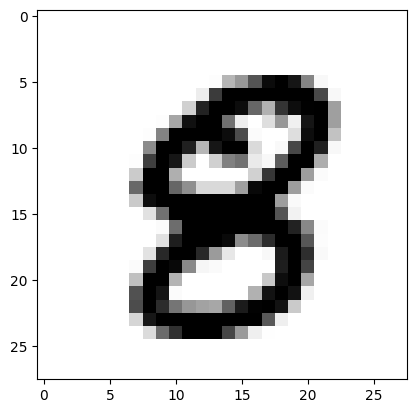

In [30]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
simple_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       ])
# Apply the transform when creating the dataset
train = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)

# # Recreate the train_loader with the updated dataset and dataloader_args
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)


# Get a batch of data from the train_loader
# Use the train_loader directly which applies the transforms
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Calculate and print statistics for the first batch
print('[Train]')
# Print shape information from the batch
print(' - Batch Tensor Shape:', images.size())

# Calculate and print min, max, mean, std, and var from the batch
print(' - min:', torch.min(images))
print(' - max:', torch.max(images))
print(' - mean:', torch.mean(images))
print(' - std:', torch.std(images))
print(' - var:', torch.var(images))


print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

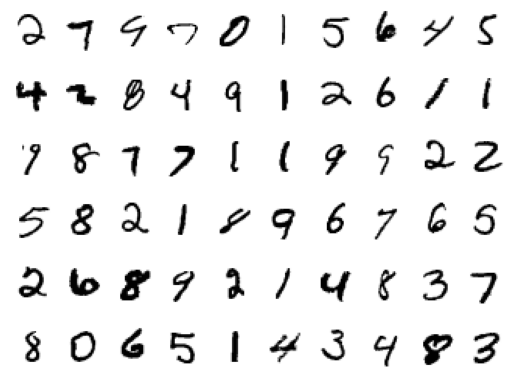

In [31]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

Lets compute mean and std deviation so that we can apply that to the dataset

In [32]:
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


### Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [33]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


### Reload the data with computed mean and std deviation

In [52]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

### Model Architecture

In [53]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 10, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(10, 16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(16, 28, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(28, 32, kernel_size=3)
        self.conv6 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv7 = nn.Conv2d(32, 10, kernel_size=3)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = self.conv7(x)
        x = x.view(-1, 10) #1x1x10> 10

        return F.log_softmax(x, dim=-1)

### Check if CUDA is available and display model parameters


In [54]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
            Conv2d-2           [-1, 10, 28, 28]             730
         MaxPool2d-3           [-1, 10, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           1,456
            Conv2d-5           [-1, 28, 14, 14]           4,060
         MaxPool2d-6             [-1, 28, 7, 7]               0
            Conv2d-7             [-1, 32, 5, 5]           8,096
            Conv2d-8             [-1, 32, 3, 3]           9,248
            Conv2d-9             [-1, 10, 1, 1]           2,890
Total params: 26,560
Trainable params: 26,560
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.10
Estimated Total Size (MB): 0.31
---------------------------------------------

### Print model architecture

In [55]:
print(model)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(28, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(32, 10, kernel_size=(3, 3), stride=(1, 1))
)


### Load train and test data, and apply transformations

In [56]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

### Training Loop

In [57]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    loss = 0
    correct = 0
    processed = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Train loss={loss.item():0.4f} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    train_losses.append(loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Model training

In [58]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
num_epochs = 15

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Epoch 1


Train loss=0.2117 batch_id=468 Accuracy=68.99: 100%|██████████| 469/469 [00:14<00:00, 32.64it/s]


Test set: Average loss: 0.1251, Accuracy: 9601/10000 (96.01%)

Epoch 2


Train loss=0.1321 batch_id=468 Accuracy=96.80: 100%|██████████| 469/469 [00:14<00:00, 31.95it/s]


Test set: Average loss: 0.0728, Accuracy: 9778/10000 (97.78%)

Epoch 3


Train loss=0.0493 batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:13<00:00, 34.10it/s]


Test set: Average loss: 0.0583, Accuracy: 9815/10000 (98.15%)

Epoch 4


Train loss=0.0407 batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:13<00:00, 33.62it/s]


Test set: Average loss: 0.0492, Accuracy: 9843/10000 (98.43%)

Epoch 5


Train loss=0.0094 batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:14<00:00, 32.97it/s]


Test set: Average loss: 0.0630, Accuracy: 9804/10000 (98.04%)

Epoch 6


Train loss=0.0222 batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:14<00:00, 32.67it/s]


Test set: Average loss: 0.0428, Accuracy: 9879/10000 (98.79%)

Epoch 7


Train loss=0.0053 batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:14<00:00, 33.36it/s]


Test set: Average loss: 0.0418, Accuracy: 9881/10000 (98.81%)

Epoch 8


Train loss=0.0466 batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:13<00:00, 33.71it/s]


Test set: Average loss: 0.0349, Accuracy: 9903/10000 (99.03%)

Epoch 9


Train loss=0.0106 batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]


Test set: Average loss: 0.0369, Accuracy: 9889/10000 (98.89%)

Epoch 10


Train loss=0.0015 batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:13<00:00, 33.96it/s]


Test set: Average loss: 0.0468, Accuracy: 9876/10000 (98.76%)

Epoch 11


Train loss=0.0073 batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:14<00:00, 32.60it/s]


Test set: Average loss: 0.0413, Accuracy: 9889/10000 (98.89%)

Epoch 12


Train loss=0.0035 batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:13<00:00, 34.13it/s]


Test set: Average loss: 0.0362, Accuracy: 9900/10000 (99.00%)

Epoch 13


Train loss=0.0203 batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:13<00:00, 33.51it/s]


Test set: Average loss: 0.0406, Accuracy: 9889/10000 (98.89%)

Epoch 14


Train loss=0.0029 batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:13<00:00, 34.02it/s]


Test set: Average loss: 0.0403, Accuracy: 9895/10000 (98.95%)

Epoch 15


Train loss=0.0275 batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:14<00:00, 32.58it/s]


Test set: Average loss: 0.0368, Accuracy: 9895/10000 (98.95%)



### Plots

Text(0.5, 1.0, 'Test Accuracy')

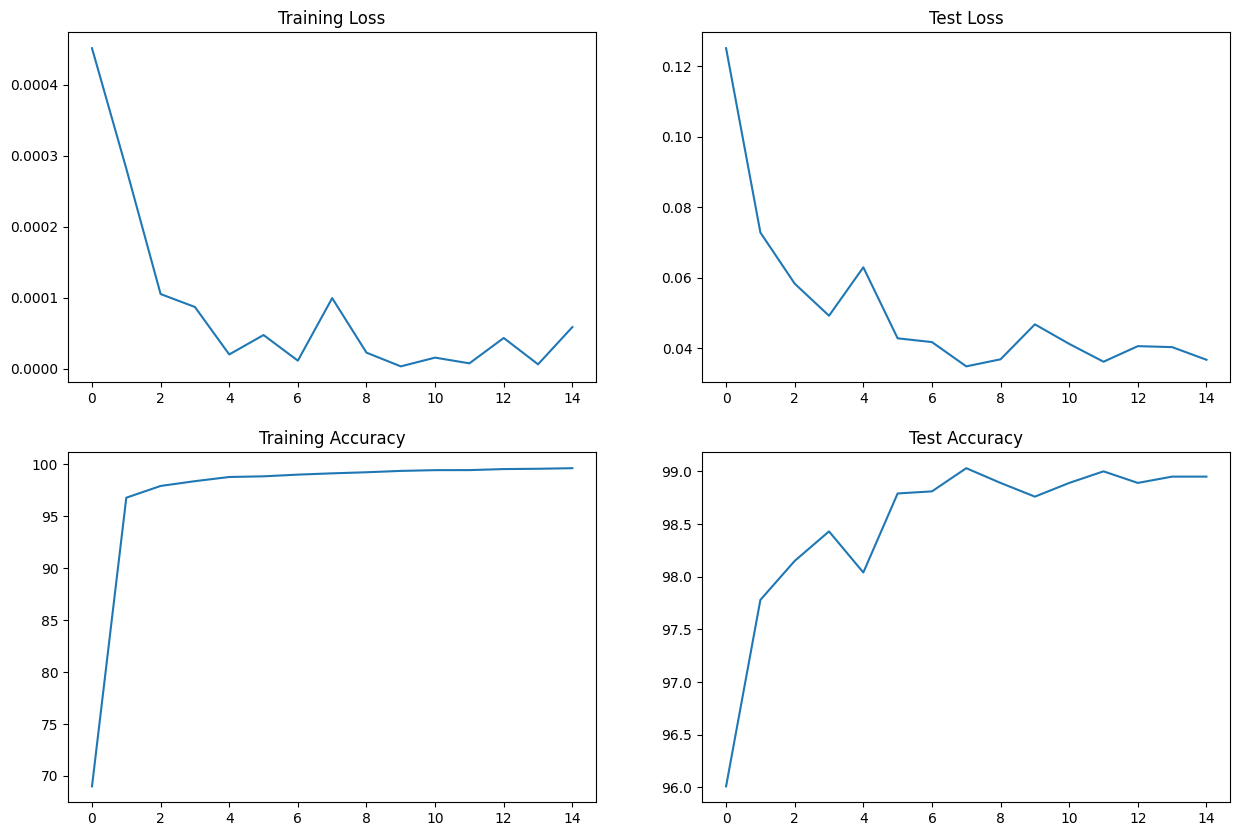

In [61]:
t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")